## Machine Learning with XGboost

Implementation of XG Boost using the custom python package. Note; there are (currently) no Scikit-learn implementation of XG boost, however the package integrates with other scikit-learn functions through the scikit-learner API (e.g.,predict(), fit()).

We will use the Hotel booking dataset. This data set contains booking information for a city hotel and a resort hotel, and includes information such as when the booking was made, length of stay, the number of adults, children, and/or babies, and the number of available parking spaces, among other things.

Links\
[XG boost package](https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand)\
[Code](https://github.com/datacamp/Machine-Learning-With-XGboost-live-training/blob/master/notebooks/Machine-Learning-with-XGBoost.ipynb)\
[Data](https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand)


### Install neccassary packages

In [2]:
# -- pip install xgboost
# -- pip install seaborn

In [198]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, ShuffleSplit
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error

import pandas as pd
import xgboost as xgb # XGBoost typically uses the alias "xgb"
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

_____

### Exploring the data

In [3]:
# Read in the dataset
bookings = pd.read_csv('https://raw.githubusercontent.com/datacamp/Machine-Learning-With-XGboost-live-training/master/data/hotel_bookings_clean.csv')

# List out our columns
bookings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119210 entries, 0 to 119209
Data columns (total 53 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     119210 non-null  int64  
 1   lead_time                       119210 non-null  int64  
 2   arrival_date_week_number        119210 non-null  int64  
 3   arrival_date_day_of_month       119210 non-null  int64  
 4   arrival_date_month              119210 non-null  int64  
 5   stays_in_weekend_nights         119210 non-null  int64  
 6   stays_in_week_nights            119210 non-null  int64  
 7   adults                          119210 non-null  int64  
 8   children                        119206 non-null  float64
 9   babies                          119210 non-null  int64  
 10  is_repeated_guest               119210 non-null  int64  
 11  previous_cancellations          119210 non-null  int64  
 12  previous_booking

In [64]:
bookings.describe()

,is_canceled,lead_time,arrival_date_week_number,arrival_date_day_of_month,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,deposit_type_No_Deposit,deposit_type_Non_Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
count,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119206.000000,119210.000000,...,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000
mean,0.370766,104.109227,27.163376,15.798717,6.552051,0.927053,2.499195,1.859206,0.104047,0.007961,...,0.017549,0.005042,0.000050,0.876277,0.122364,0.001359,0.034158,0.004815,0.750575,0.210452
std,0.483012,106.875450,13.601107,8.781070,3.089796,0.995117,1.897106,0.575186,0.398842,0.097509,...,0.131305,0.070825,0.007094,0.329266,0.327707,0.036839,0.181636,0.069223,0.432682,0.407631
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,18.000000,16.000000,8.000000,4.000000,0.000000,1.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,69.000000,28.000000,16.000000,7.000000,1.000000,2.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,161.000000,38.000000,23.000000,9.000000,2.000000,3.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,737.000000,53.000000,31.000000,12.000000,19.000000,50.000000,55.000000,10.000000,10.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


[Text(0, 0, '62.92%'), Text(0, 0, '37.08%')]

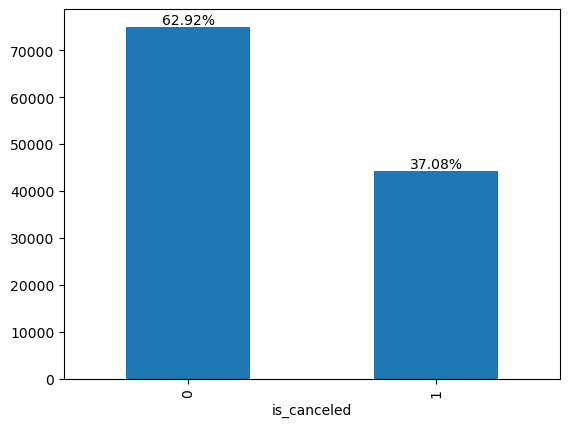

In [57]:
ax = bookings['is_canceled'].value_counts().plot(kind='bar')
ax.bar_label(ax.containers[0], fmt=lambda x: f'{(x/len(bookings))*100:.2f} %')

<Axes: >

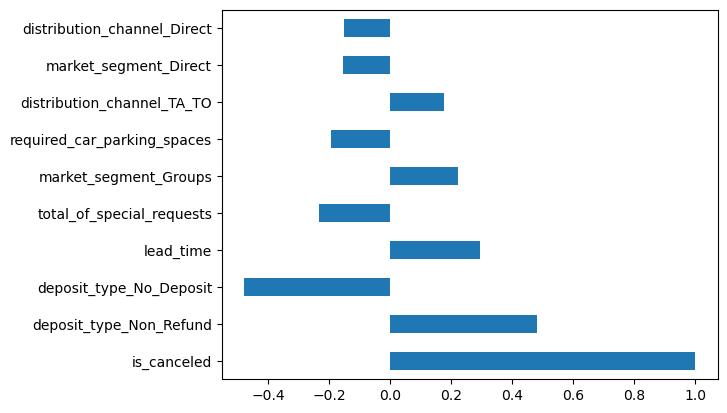

In [46]:
#bookings.corr()['is_canceled'].abs().sort_values(ascending=False).head(10)
bookings[bookings.corr()['is_canceled'].abs().sort_values(ascending=False).head(10).index.to_list()].corrwith(bookings['is_canceled']).plot(kind='barh')


In [80]:
print(" Count total NaN at each column in the dataset : \n\n",bookings.isnull().sum()) 

 Count total NaN at each column in a DataFrame : 

 is_canceled                       0
lead_time                         0
arrival_date_week_number          0
arrival_date_day_of_month         0
arrival_date_month                0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          4
babies                            0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
required_car_parking_spaces       0
total_of_special_requests         0
avg_daily_rate                    0
booked_by_company                 0
booked_by_agent                   0
hotel_City                        0
hotel_Resort                      0
meal_BB                           0
meal_FB                           0
meal_HB                           0
meal_No_meal                      0
market_segment_Aviation           0
market_segment_Complementary      0
market_segme

In [ ]:
print(bookings.avg_daily_rate.describe())
#print(f'Count of daily rate < 0: {sum(np.array(bookings.avg_daily_rate)<0)}')
#print(f'at index: {np.where(bookings.avg_daily_rate<0)[0]}')

_____

### Prepare data for training

In [89]:
scaler = MinMaxScaler()
bookings_scaled = scaler.fit_transform(bookings)
bookings_scaled = pd.DataFrame(bookings_scaled, columns=bookings.columns)
bookings_scaled.describe()

In [186]:
X, y = bookings_scaled.iloc[:,1:], bookings.iloc[:,0]
# Train and test split using sklearn
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=.33, random_state=123)

### Initiate the model

In [189]:
xgb_clf = xgb.XGBClassifier(random_state=123)

In [98]:
xgb_clf.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 123,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

**booster** - the weak learner in this model. gbtree is the default.\
**objective function (loss function)** - how far off a prediction is from the actual results. binary:logistic is the default for classifiers.\
**n_estimators** - the number of gradient boosted trees/number of boosting rounds.\
**max_depth** - is the maximum tree depth allowed. Default is 6

List of all parameters [here](https://xgboost.readthedocs.io/en/stable/parameter.html)

In [163]:
# Fit it to the training set
xgb_clf.fit(X_train, y_train)

# Predict the labels of the test set
preds = xgb_clf.predict(X_test)

In [164]:
# Calculate the accuracy
accuracy = float(np.sum(preds==y_test))/y_test.shape[0]

# Print the baseline accuracy
print(f'Baseline accuracy: {accuracy*100:.2f}%')

Baseline accuracy: 83.91%


In [108]:
def display_scores(scores):
    print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))

In [155]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scores_kfold = []

for train_index, test_index in kfold.split(X):   
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb_model = xgb.XGBClassifier()
    xgb_model.fit(X_train, y_train)
    
    y_pred = xgb_model.predict(X_test)
    
    scores_kfold.append(float(np.sum(y_pred==y_test))/y_test.shape[0])

In [160]:
#cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
scores_cv = cross_val_score(xgb_clf, X, y, scoring="accuracy", cv=5) # cv

In [162]:
display_scores(scores_kfold)
#display_scores(scores_cv)

Scores: [0.8403237983390656, 0.8419595671504069, 0.8401560271789279, 0.8417917959902693, 0.8391494002181025]
Mean: 0.841
Std: 0.001


*Note on cross validation folds:*

>**cross_val_score** will use a StratifiedKFold cv iterator when not specified otherwise. A StratifiedKFold will keep the *<u>ratio of classes balanced</u>* the same way in train and test split. On the other hand, in your first approach you are using **KFold** which will *<u>not keep the balance of classes.</u>* In addition you are doing shuffling of data in that. So in each fold, there is data difference in your two approaches and hence different results.

*read this [tread](https://stackoverflow.com/questions/52242492/difference-between-cross-val-score-and-another-way-of-calculating-accuracy) for more info.*

### Plotting feature importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

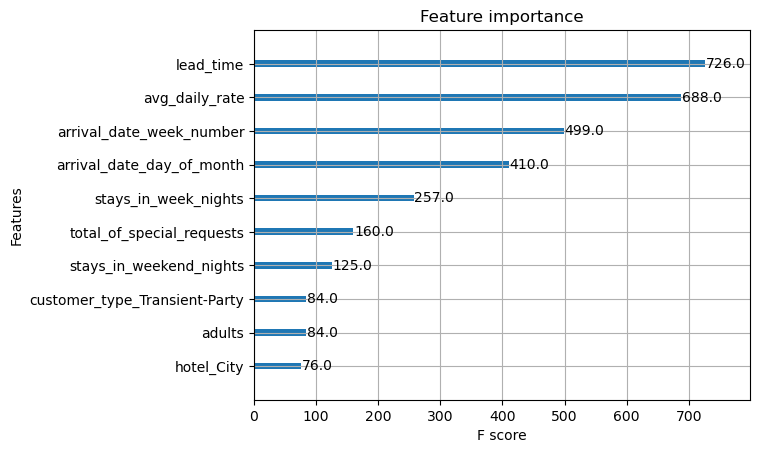

In [105]:
xgb.plot_importance(xgb_clf,max_num_features=10, importance_type="weight")

The ordering of features differs quite a bit between gain and weight. This implies that 
1. feature importance can be subjective, and 
2. the number of appearances a feature has on a tree is not necessarily correlated to how much gain it brings. For example, a binary variable has less of a chance to appear as many times as a continuous variable on a tree, since there are only two outputs. However, it can still be a powerful feature.

From the documentation:
>How the importance is calculated: either “weight”, “gain”, or “cover”:
>* ”weight” is the number of times a feature appears in a tree
>* ”gain” is the average gain of splits which use the feature
>* ”cover” is the average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split

***

### Parameters of XG boost

**N estimates** - Number of boostings/trees

<img src=https://camo.githubusercontent.com/24205a4a34dc957b0f57294bda549f4400e51f1811cda183832f41bc54575b30/68747470733a2f2f6769746875622e636f6d2f6461746163616d702f4d616368696e652d4c6561726e696e672d576974682d5847626f6f73742d6c6976652d747261696e696e672f626c6f622f6d61737465722f6173736574732f6e5f657374696d61746f72732e706e673f7261773d74727565 width=400>

In [172]:
## Set number of trees/boostings to be 30
xgb_clf.set_params(n_estimators=10)

xgb_clf.fit(X_train, y_train)
preds = xgb_clf.predict(X_test)
print(f'Accuracy with N boosting trees = 30: {accuracy_score(y_test, preds)*100:.5f}%')

Accuracy with N boosting trees = 30: 85.01%


**Max depth** - Increasing this value will make the model more complex and more likely to overfit.

<img src=https://camo.githubusercontent.com/4a3acd81d8ce64acb90822870180fff8fa491c83b4f309e1fa5503a55634b9dd/68747470733a2f2f6769746875622e636f6d2f6461746163616d702f4d616368696e652d4c6561726e696e672d576974682d5847626f6f73742d6c6976652d747261696e696e672f626c6f622f6d61737465722f6173736574732f6d61785f64657074682e706e673f7261773d74727565 width=300>

In [173]:
# Set max_depth to 10
xgb_clf.set_params(max_depth=20)

xgb_clf.fit(X_train, y_train)
preds = xgb_clf.predict(X_test)
print(f'Accuracy with Max depth = 10: {accuracy_score(y_test, preds)*100:.5f}%')

Accuracy with Max depth = 10: 85.01%


**Gamma** - represents the minimum loss reduction required for a node to split. This decides whether a node will split based on the expected loss reduction loss after the split. The larger gamma is, the more conservative the algorithm will be.

<img src=https://camo.githubusercontent.com/97a598939233fc5cbfb563f3984a33df66e9d504cd3abf16001c01246c76539a/68747470733a2f2f6769746875622e636f6d2f6461746163616d702f4d616368696e652d4c6561726e696e672d576974682d5847626f6f73742d6c6976652d747261696e696e672f626c6f622f6d61737465722f6173736574732f67616d6d612e706e673f7261773d74727565 width=300>

In [174]:
# Set gamma to .25 
xgb_clf.set_params(gamma=0.25)

xgb_clf.fit(X_train, y_train)
preds = xgb_clf.predict(X_test)
print(f'Accuracy with Gamma = .25: {accuracy_score(y_test, preds)*100:.5f}%')

Accuracy with Gamma = .25: 85.03%


**Learning rate** -  shrinking the resulting weights of the current tree before passing them on to the next tree. \
*Note: The learning rate and the number of trees should be tuned together. If we decrease the learning rate, we need to make sure we have enough trees to learn something and avoid severely underfitting. Therefore, a low learning will require more boosting rounds.*

In [179]:
# Set learning rate to 0.3
xgb_clf.set_params(learning_rate=0.3)

xgb_clf.fit(X_train, y_train)
preds = xgb_clf.predict(X_test)
print(f'Accuracy with LR = .3: {accuracy_score(y_test, preds)*100:.5f}%')

Accuracy with LR = .3: 85.03062%


**Early stopping**

In [212]:
## Increase the number of trees/boostings to be 40 and set early stopping
xgb_clf.set_params(n_estimators=40, early_stopping_rounds=5)

xgb_clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])
preds = xgb_clf.predict(X_test)
print(f'Accuracy with early stopping: {accuracy_score(y_test, preds)*100:.5f}%')

[0]	validation_0-logloss:0.55611	validation_1-logloss:0.55634
[1]	validation_0-logloss:0.50246	validation_1-logloss:0.50342
[2]	validation_0-logloss:0.47101	validation_1-logloss:0.47218
[3]	validation_0-logloss:0.45061	validation_1-logloss:0.45202
[4]	validation_0-logloss:0.43589	validation_1-logloss:0.43759
[5]	validation_0-logloss:0.42531	validation_1-logloss:0.42735
[6]	validation_0-logloss:0.41685	validation_1-logloss:0.41930
[7]	validation_0-logloss:0.41169	validation_1-logloss:0.41431
[8]	validation_0-logloss:0.40755	validation_1-logloss:0.41031
[9]	validation_0-logloss:0.40382	validation_1-logloss:0.40668
[10]	validation_0-logloss:0.39968	validation_1-logloss:0.40289
[11]	validation_0-logloss:0.39779	validation_1-logloss:0.40135
[12]	validation_0-logloss:0.39630	validation_1-logloss:0.40002
[13]	validation_0-logloss:0.39271	validation_1-logloss:0.39653
[14]	validation_0-logloss:0.39031	validation_1-logloss:0.39443
[15]	validation_0-logloss:0.38937	validation_1-logloss:0.39356
[1

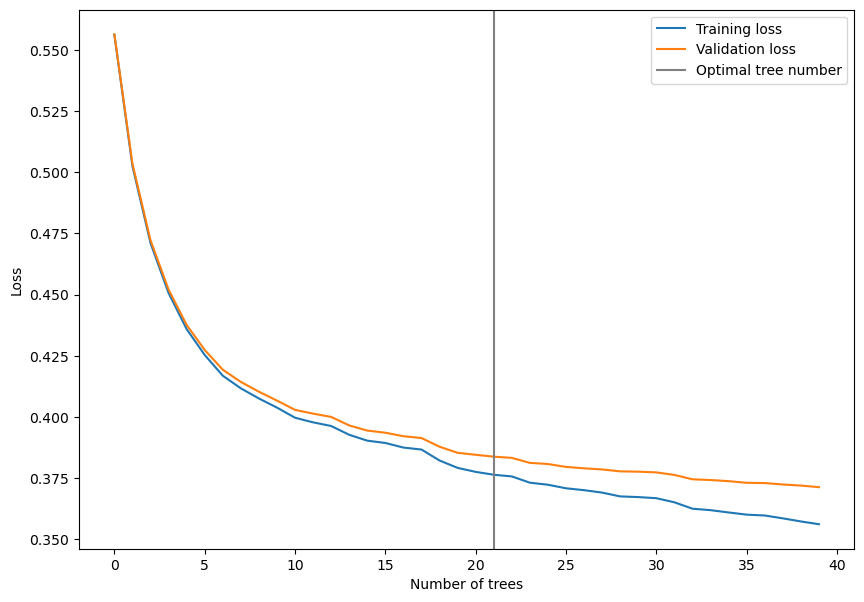

In [213]:
results = xgb_clf.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["logloss"], label="Training loss")
plt.plot(results["validation_1"]["logloss"], label="Validation loss")
plt.axvline(21, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

In [214]:
xgb_clf.best_iteration

39

***

### Hyperparamter tuning using Scikit-learn API

**Grid search vs Random Search** - depending on the size of your hyperparameter space. Grid search over the entire space, while random uses a fixed number of settings sampled from a the space.

<img src=https://camo.githubusercontent.com/cd18cac9ba3539d1d33593b95f1495cb6c2c1a756a80b6d24fe2ea6f4758cbb6/68747470733a2f2f6769746875622e636f6d2f6461746163616d702f4d616368696e652d4c6561726e696e672d576974682d5847626f6f73742d6c6976652d747261696e696e672f626c6f622f6d61737465722f6173736574732f72616e646f6d697a65645f7365617263685f312e6769663f7261773d74727565 width=300>

In [180]:
# Define a parameter grid
rs_param_grid = {
    'max_depth': list((range(3,12))),
    'alpha': [0,0.001, 0.01,0.1,1],
    'subsample': [0.5,0.75,1],
    'learning_rate': np.linspace(0.01,0.5, 10),
    'n_estimators': [10, 25, 40]
    }

In [183]:
# Insantiate a new XGBoost Clasifier 
xgb_clf = xgb.XGBClassifier(random_state=123)

# Instantiate RandomizedSearchCV()
xgb_rs = RandomizedSearchCV(estimator=xgb_clf,param_distributions=rs_param_grid, 
                                cv=3, n_iter=5, verbose=2, random_state=123)

xgb_rs.fit(X_train, y_train)
print("Best parameters found: ", xgb_rs.best_params_)
print("Best accuracy found: ", xgb_rs.best_score_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END alpha=1, learning_rate=0.22777777777777777, max_depth=5, n_estimators=10, subsample=0.5; total time=   0.1s
[CV] END alpha=1, learning_rate=0.22777777777777777, max_depth=5, n_estimators=10, subsample=0.5; total time=   0.1s
[CV] END alpha=1, learning_rate=0.22777777777777777, max_depth=5, n_estimators=10, subsample=0.5; total time=   0.1s
[CV] END alpha=1, learning_rate=0.11888888888888888, max_depth=6, n_estimators=40, subsample=1; total time=   0.2s
[CV] END alpha=1, learning_rate=0.11888888888888888, max_depth=6, n_estimators=40, subsample=1; total time=   0.2s
[CV] END alpha=1, learning_rate=0.11888888888888888, max_depth=6, n_estimators=40, subsample=1; total time=   0.2s
[CV] END alpha=1, learning_rate=0.11888888888888888, max_depth=8, n_estimators=40, subsample=0.75; total time=   0.2s
[CV] END alpha=1, learning_rate=0.11888888888888888, max_depth=8, n_estimators=40, subsample=0.75; total time=   0.2s
[CV] END